# Democracy and Autocracy

Most people would prefer to live in a democratic country where rulers are elected and accountable to the people, rather than an autocratic country where rulers have unlimited power.
And most people value individual liberties like freedom of expression and freedom of association.

Before 1900, democracy and liberty were rare: most countries were "closed autocracies" where citizens had no right to vote.
But that changed dramatically over the last 100 years.

The following figure shows the percentage of countries in each of four categories defined by the [Regimes of the World (RoW) project](https://www.cogitatiopress.com/politicsandgovernance/article/view/1214).

<img src="https://raw.githubusercontent.com/AllenDowney/DataWorld/main/figs/countries-democracies-autocracies-row.png">

This figure is from Our World in Data, which collects the data and makes it available for download.
They summarize the categories like this.

>* In _closed autocracies_, citizens do not have the right to either choose the chief executive of the government or the legislature through multi-party elections.
>
>* In _electoral autocracies_, citizens have the right to choose the chief executive and the legislature through multi-party elections; but they lack some freedoms, such as the freedoms of association or expression, that make the elections meaningful, free, and fair.
>
>* In _electoral democracies_, citizens have the right to participate in meaningful, free and fair, and multi-party elections.
>
>* In _liberal democracies_, citizens have further individual and minority rights, are equal before the law, and the actions of the executive are constrained by the legislature and the courts.

Although the number of democratic countries has increased greatly over the last 100 years, it has decreased somewhat over the last 10 years.
To explore these trends, let's look more closely at the data.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataWorld/blob/main/nb/XXX.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataWorld/raw/main/nb/utils.py')

'utils.py'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate, value_counts

In [4]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data

The following cells download the data from Our World in Data, along with metadata that contains information about the data.

In [5]:
base_url = "https://ourworldindata.org/grapher/political-regime"

params = {
    "v": "1",
    "csvType": "full",
    "useColumnShortNames": "true",
}

headers = {"User-Agent": "Our World In Data data fetch/1.0"}

<IPython.core.display.Javascript object>

In [6]:
import requests
from urllib.parse import urlencode

url = f"{base_url}.csv?{urlencode(params)}"
df = pd.read_csv(url, storage_options=headers)

<IPython.core.display.Javascript object>

In [7]:
# Select data from 1900 to the present

df = df.query("Year >= 1900")
df.head()

,Entity,Code,Year,regime_row_owid
111,Afghanistan,AFG,1900,0
112,Afghanistan,AFG,1901,0
113,Afghanistan,AFG,1902,0
114,Afghanistan,AFG,1903,0
115,Afghanistan,AFG,1904,0


<IPython.core.display.Javascript object>

In [8]:
url = f"{base_url}.metadata.json"
response = requests.get(url, params=params, headers=headers)
metadata = response.json()

<IPython.core.display.Javascript object>

In [9]:
from pprint import pprint

metadata_col = metadata["columns"]["regime_row_owid"]
pprint(metadata_col["citationLong"])

('V-Dem (2024) – processed by Our World in Data. “Political regime” [dataset]. '
 'V-Dem, “V-Dem Country-Year (Full + Others) v14” [original data].')


<IPython.core.display.Javascript object>

In [10]:
t = metadata_col["descriptionKey"]
print("\n\n".join(t))

The indicator uses the Regimes of the World classification by political scientists Anna Lührmann, Marcus Tannenberg and Staffan Lindberg.

The classification distinguishes between closed autocracies (score 0), electoral autocracies (score 1), electoral democracies (score 2), and liberal democracies (score 3).

In _closed autocracies_, citizens do not have the right to either choose the chief executive of the government or the legislature through multi-party elections.

In _electoral autocracies_, citizens have the right to choose the chief executive and the legislature through multi-party elections; but they lack some freedoms, such as the freedoms of association or expression, that make the elections meaningful, free, and fair.

In _electoral democracies_, citizens have the right to participate in meaningful, free and fair, and multi-party elections.

In _liberal demoracies_, citizens have further individual and minority rights, are equal before the law, and the actions of the executi

<IPython.core.display.Javascript object>

In [11]:
# Reformat the data as a DataFrame with one row for each country
# and one column for each year

data = df.set_index(["Entity", "Year"])["regime_row_owid"].unstack()
data.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       ...
       'Vanuatu', 'Venezuela', 'Vietnam', 'West Germany', 'Yemen',
       'Yemen Arab Republic', 'Yemen People's Republic', 'Zambia', 'Zanzibar',
       'Zimbabwe'],
      dtype='object', name='Entity', length=186)

<IPython.core.display.Javascript object>

In [12]:
data.columns

Index([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       ...
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int64', name='Year', length=124)

<IPython.core.display.Javascript object>

## Recent Changes

In [13]:
# we'll use these lists to translate between the integer codes
# in the DataFrame and the names of the categories

codes = [0, 1, 2, 3]

categories = [
    "closed autocracy",
    "electoral autocracy",
    "electoral democracy",
    "liberal democracy",
]

<IPython.core.display.Javascript object>

In [14]:
def columnwise_counts(data):
    """Compute a DataFrame that contains value counts for each column.

    data: DataFrame with one row per country, one column per year

    returns: DataFrame with one row per value, one column per year
    """
    counts = pd.DataFrame(index=codes, columns=data.columns)
    for year in data.columns:
        counts[year] = data[year].value_counts()
    return counts

<IPython.core.display.Javascript object>

In [15]:
counts = columnwise_counts(data)

<IPython.core.display.Javascript object>

In [16]:
year2 = 2023
counts[year2].to_frame()

,2023
0,34
1,54
2,59
3,32


<IPython.core.display.Javascript object>

In [17]:
from utils import underride


def plot_counts(counts, year, **options):
    """Horizontal bar chart of counts during a single year.

    counts: DataFrame
    year: integer
    options: passed to plot()
    """
    underride(options, alpha=0.6)
    counts[year].plot(kind="barh", **options)
    plt.yticks(codes, categories)
    decorate(xlabel="Number of countries", ylabel="Category")

<IPython.core.display.Javascript object>

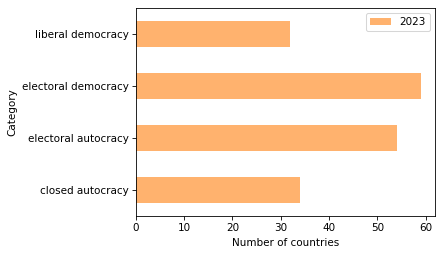

<IPython.core.display.Javascript object>

In [18]:
plot_counts(counts, year2, color="C1")

The most common regime type is electoral democracy, followed by electoral autocracy.

Let's compare the distribution of regime types in 2023 to the distribution 10 years ago, roughly at the high point of democracy.

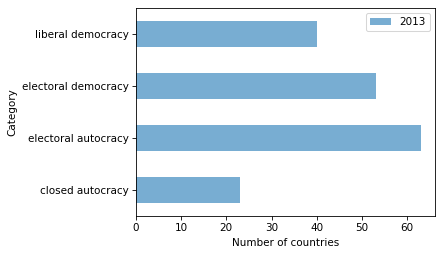

<IPython.core.display.Javascript object>

In [19]:
year1 = 2013
plot_counts(counts, year1)

It is easier to compare the distributions if we plot them on the same axes.

In [20]:
def two_bar_plots(dist1, dist2, width=0.45, **options):
    """ """
    underride(options, alpha=0.6)
    dist1.plot(kind="barh", color="C0", align="edge", width=width, **options)
    dist2.plot(kind="barh", color="C1", align="edge", width=-width, **options)

<IPython.core.display.Javascript object>

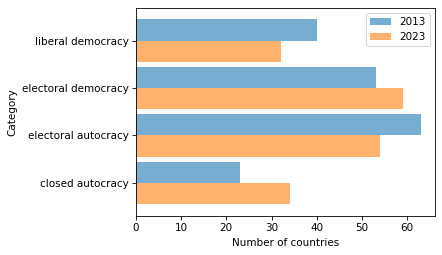

<IPython.core.display.Javascript object>

In [21]:
two_bar_plots(counts[year1], counts[year2])
plt.yticks(codes, categories)
decorate(xlabel="Number of countries", ylabel="Category", ylim=[-0.7, 3.7])

Now we can see the differences more clearly:

* The numbers of liberal democracies (3) and electoral autocracies (1) have decreased.

* The numbers of electoral democracies (2) and closed autocracies (0) have increased.

These results suggest that some liberal democracies have become electoral democracies (3 to 2) and some electoral autocracies have become close autocracies (1 to 0).

To see whether that interpretation is correct, we can make a table that shows the number of countries that made a transition from one category to another between 2013 and 2023.

In [22]:
def make_transitions(data, year1, year2):
    """Number of countries that transitioned from one category to another.

    data: DataFrame
    year1: start year
    year2: end year
    """
    labels = categories
    transitions = pd.crosstab(data[year1], data[year2])
    transitions.index = pd.Index(labels, name=year1)
    transitions.columns = pd.Index(labels, name=year2)
    return transitions

<IPython.core.display.Javascript object>

In [23]:
transitions = make_transitions(data, year1, year2)
transitions

2023,closed autocracy,electoral autocracy,electoral democracy,liberal democracy
2013,,,,
closed autocracy,19,3,1,0
electoral autocracy,12,40,10,1
electoral democracy,3,10,36,4
liberal democracy,0,1,12,27


<IPython.core.display.Javascript object>

Reading across the top row, we can see that of the closed autocracies in 2013, 19 were unchanged in 2023, three became electoral autocracies, and one leaped all the way to an electoral democracy (Fiji).

<a title="TUBS, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Fiji_on_the_globe_(small_islands_magnified)_(Polynesia_centered).svg"><img width="256" alt="Fiji on the globe (small islands magnified) (Polynesia centered)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Fiji_on_the_globe_%28small_islands_magnified%29_%28Polynesia_centered%29.svg/512px-Fiji_on_the_globe_%28small_islands_magnified%29_%28Polynesia_centered%29.svg.png?20110511144714"></a>

In [26]:
def find_transitions(data, year1, year2, cat1, cat2):
    """Select the rows that moved from one category to another."""
    before = data[year1] == cat1
    after = data[year2] == cat2
    return data.loc[before & after, year1:year2]

<IPython.core.display.Javascript object>

In [28]:
find_transitions(data, year1, year2, 0, 2)

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Entity,,,,,,,,,,,
Fiji,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


<IPython.core.display.Javascript object>

Reading the last row, of liberal democracies in 2013, 12 became electoral democracies and one regressed to an electoral autocracy (Mauritius).

<a title="Yashveer Poonit, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Mauritius_(orthographic_projection_with_inset).svg"><img width="256" alt="Mauritius (orthographic projection with inset)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Mauritius_%28orthographic_projection_with_inset%29.svg/256px-Mauritius_%28orthographic_projection_with_inset%29.svg.png?20120929134017"></a>

In [27]:
find_transitions(data, year1, year2, 3, 1)

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Entity,,,,,,,,,,,
Mauritius,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


<IPython.core.display.Javascript object>

Another way to represent this matrix of transition is with a heatmap where the colors represent the number of countries in each cell.

In [24]:
import seaborn as sns


def plot_transitions(transitions):
    sns.heatmap(
        transitions,
        annot=True,
        annot_kws={"size": 14},
        fmt="d",
        cmap="YlGnBu",
        cbar=False,
    )
    plt.xticks(rotation=30)

<IPython.core.display.Javascript object>

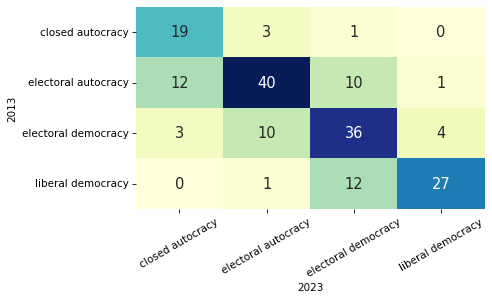

<IPython.core.display.Javascript object>

In [25]:
plot_transitions(transitions)

Of the electoral autocracies in 2013, how many were democracies (of either kind) in 2023?

Of the electoral democracies in 2013, how many were autocracies (of either kind) in 2023?

If you would like to explore this data, you can use the pulldown menus below to select categories and see the countries that transitioned from one to another.
What which countries transitioned from electoral democracies to closed autocracies?

In [43]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display


def make_interactive(data, year1, year2):
    # Create dropdown widgets
    cat1_dropdown = widgets.Dropdown(options=categories, description=f"{year1}")
    cat2_dropdown = widgets.Dropdown(options=categories, description=f"{year2}")

    # Function to update the output
    def update_output(cat1, cat2):
        d = dict(zip(categories, codes))
        result = find_transitions(data, year1, year2, d[cat1], d[cat2])
        display(result)

    # Create interactive widgets
    interactive_widget = widgets.interactive(
        update_output, cat1=cat1_dropdown, cat2=cat2_dropdown
    )

    # Display widgets
    display(interactive_widget)

<IPython.core.display.Javascript object>

In [44]:
make_interactive(data, year1, year2)

interactive(children=(Dropdown(description='2013', options=('closed autocracy', 'electoral autocracy', 'electo…

<IPython.core.display.Javascript object>

## The Long View

So far we're been looking at data from the last 10 years.
Now let's take a longer view, going back to 1900.
The following graph shows the number of countries in each category over time from 1900 to 2023.

In [56]:
count_series = counts.transpose()
count_series.columns = pd.Index(categories)
xlim = count_series.index.min(), count_series.index.max()

<IPython.core.display.Javascript object>

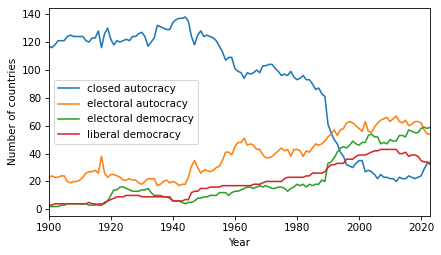

<IPython.core.display.Javascript object>

In [57]:
count_series.plot()
decorate(ylabel="Number of countries", xlim=xlim)

We can see that the number of closed autocracies decreased over this period, gradually between 1940 and 1980, and then more steeply between 1980 and 2000 -- arguably the greatest advance in democracy and liberty in world history.

Which categories were increasing during this period?
Which has decreased the most in the last 10 years?

Consider asking a virtual assistant:

* "Between 1940 and 1980, what caused the gradual decrease in the number of closed autocracies?"

* "What happened around 1990 that rapidly reduced the number of closed autocracies in the world?"

Another way to view the same data is with a stacked area chart.

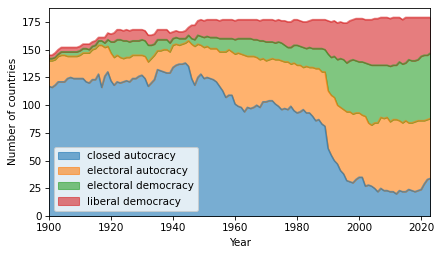

<IPython.core.display.Javascript object>

In [58]:
count_series.plot.area(alpha=0.6)
decorate(ylabel="Number of countries", xlim=xlim)

One advantage of the stacked view is that we can also see the total number of countries, which increased between 1900 and 1950.
It also makes it easier to compare the total number of autocracies (of either kind) and democracies.

Are there other patterns you think are easier to see in one view of the data or the other?

## One Hundred Years of Regimes

Over the last 100 years, democracy and liberty have expanded in many countries.
To see these long-term trends more clearly, let's compare the distribution of regime categories between 1923 and 2023.

In [34]:
year0 = 1923
counts[year0]

0    120
1     23
2     16
3      9
Name: 1923, dtype: int64

<IPython.core.display.Javascript object>

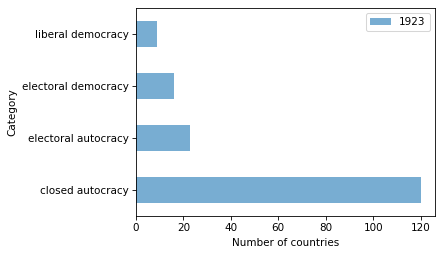

<IPython.core.display.Javascript object>

In [47]:
plot_counts(counts, year0)

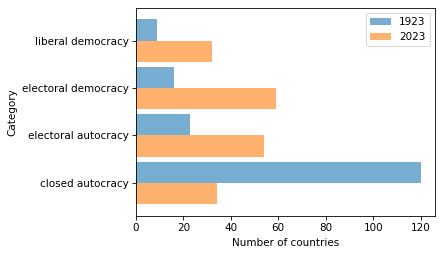

<IPython.core.display.Javascript object>

In [51]:
two_bar_plots(counts[year0], counts[year2])
plt.yticks(codes, categories)
decorate(xlabel="Number of countries", ylabel="Category", ylim=[-0.7, 3.7])

Over the last 100 years, which category decreased the most?
Which category increased the most?

The following table shows the transitions that happened over the last 100 years.

In [46]:
transitions100 = make_transitions(data, year0, year2)
transitions100

2023,closed autocracy,electoral autocracy,electoral democracy,liberal democracy
1923,,,,
closed autocracy,28,46,34,8
electoral autocracy,1,4,15,3
electoral democracy,0,0,4,12
liberal democracy,0,0,0,9


<IPython.core.display.Javascript object>

And here's the same data in a heatmap.

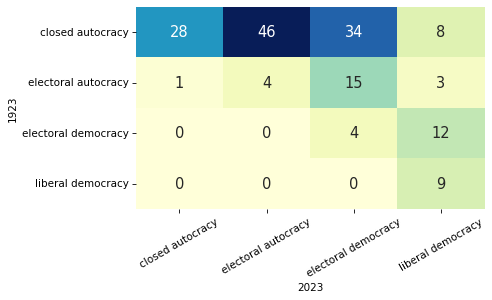

<IPython.core.display.Javascript object>

In [35]:
plot_transitions(transitions100)

Of the countries that were closed autocracies in 1923, what category are most of them in now?

Of you countries that were liberal democracies in 1923, how many of them still are?

In [36]:
make_transitions(data, year0, year2)

2023,closed autocracy,electoral autocracy,electoral democracy,liberal democracy
1923,,,,
closed autocracy,28,46,34,8
electoral autocracy,1,4,15,3
electoral democracy,0,0,4,12
liberal democracy,0,0,0,9


<IPython.core.display.Javascript object>

The following are the countries that advanced from electoral democracy to liberal democracy over this period.

In [38]:
find_transitions(data, year0, year2, 2, 3)

Year,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Entity,,,,,,,,,,,,,,,,,,,,,
Canada,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0
Czechia,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0
Estonia,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Finland,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
France,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Germany,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Ireland,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Latvia,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Luxembourg,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


<IPython.core.display.Javascript object>

If you would like to explore this data, you can use the pulldown menus below to select categories and see the countries that transitioned from one to another.

In [45]:
make_interactive(data, year0, year2)

interactive(children=(Dropdown(description='1923', options=('closed autocracy', 'electoral autocracy', 'electo…

<IPython.core.display.Javascript object>

For more on this topic, you might be interested in this article by Bastian Herre at Our World in Data: "[The world has recently become less democratic](https://ourworldindata.org/less-democratic)", 2022.

[AP Statistics Learning Objectives](https://apcentral.collegeboard.org/media/pdf/ap-statistics-course-and-exam-description.pdf):

**Topic 1.3**

* Represent categorical data using frequency or relative frequency tables.

* Describe categorical data
represented in frequency or
relative tables.

**Topic 1.4**

* Represent categorical data graphically.

* Describe categorical data represented graphically.

* Compare multiple sets of categorical data.

**Topic 2.2**

* Compare numerical and graphical representations for two categorical variables.

[*Data World: Understanding Our World With Data*](https://allendowney.github.io/DataWorld/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)